# Setup



## Colab setup
---------- Start of generic setup code to get kaggle credentials login and data to work with. Copied much from Workshop 2 ----------

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
!pip install -U -q scikeras
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

^C
ERROR: Operation cancelled by user


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

https://drive.google.com/file/d/1DeYgEzZ8Bs8Y3QsHd5YsV-3D-SzVAm4x

In [ ]:
# GET data from file I've uploaded to my drive. Use your own kaggle.json and google auth logins etc
downloaded = drive.CreateFile({"id": "1DeYgEzZ8Bs8Y3QsHd5YsV-3D-SzVAm4x"})
downloaded.GetContentFile("predict-energy-consumption.zip")

In [ ]:
!unzip predict-energy-consumption.zip

!ls
!mkdir data
!mv *.csv data/

In [ ]:
from google.colab import files

files.upload()
# upload your kaggle.json file

Processing data from the source.

In [ ]:
import json

!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

In [ ]:
# GENERIC SUBMIT FUNCTION (uncomment when you want to submit)

# submission = pd.DataFrame(
#    {'key': test.key, 'fare_amount': val_predictions},
#    columns = ['key', 'fare_amount'])
# submission.to_csv('submission.csv', index = False)


#!kaggle competitions submit -c predict-electricity-consumption -f submission.csv -m "[TEAM NAME] Submission"

## Libraries setup

In [95]:
!pip install -U -q darts
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

# Data exploration

### Modification functions

In [76]:
def replaceNanWithZero(test, train, labels):
    train_labels = labels.replace(np.nan, 0.0)

    for col in train.columns:
        train[col] = train[col].replace(np.nan, 0.0)

    for col in test.columns:
        test[col] = test[col].replace(np.nan, 0.0)

    return test, train, train_labels

In [77]:
# PCA to get a lesser number of features, then going to feed into basic nn see what we can do
from sklearn.decomposition import PCA


def PCA_Performance(train, test):
    variance = [0.5, 0.6, 0.75, 0.8, 0.85, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99]

    for var in variance:
        pca = PCA(n_components=var)
        pca.fit(train)
        transformed_Train = pca.transform(train)
        # transformed_Test = pca.transform(test)
        print(
            f"Retained {var} of variance with {len(transformed_Train.T)} number of features"
        )

In [78]:
def month_to_season(month: int) -> str:
    assert 1 <= month < 13
    if 3 <= month < 6:
        return "spring"
    elif 6 <= month < 9:
        return "summer"
    elif 9 <= month < 12:
        return "autumn"
    else:
        return "winter"

In [79]:
def cast_types(df: pd.DataFrame) -> pd.DataFrame:

    # Cast time, respect timezone
    df["time"] = pd.to_datetime(df["time"], utc=True).dt.tz_convert("Europe/Tallinn")

    # Cast remaining columns
    df = df.astype(
        {
            "temp": "float32",
            "dwpt": "float32",
            "rhum": "int32",
            "prcp": "float32",
            # TODO: Snow might be integer too, check it
            "snow": "float32",
            "wdir": "int32",
            "wspd": "float32",
            "wpgt": "float32",
            "pres": "float32",
            "coco": "category",
            "el_price": "float32",
        }
    )

    # Change coco categories from float to int representation
    new_categories = [int(category) for category in df["coco"].cat.categories]

    df["coco"] = df["coco"].cat.rename_categories(new_categories)

    return df

In [80]:
def explode_datetime(
    df: pd.DataFrame, datetime_column: str, without_prefix: bool = False
) -> pd.DataFrame:

    prefix = "" if without_prefix else f"{datetime_column}_"

    if f"{prefix}year" in df.columns:
        print(f"Column {prefix}year already exists")
        return df

    date_info = pd.DataFrame(
        data=[
            [x.year, x.month, x.day, x.hour, x.weekday()] for x in df[datetime_column]
        ],
        columns=[
            f"{prefix}year",
            f"{prefix}month",
            f"{prefix}day",
            f"{prefix}hour",
            f"{prefix}weekday",
        ],
    ).astype(np.int32)

    df = pd.concat([df.reset_index(), date_info], axis=1).set_index("index")

    return df

## Exploration

In [81]:
# Here we can split into train/test for verification while we train whatever works)
train = pd.read_csv("data/train.csv")
train_labels = train["consumption"]  # y vals in this case are concumption
# GIVEN time is a string we just gonna drop that mfer, cbf processing it etc

test = pd.read_csv("data/test.csv")

# Have to predict consumption for these values. Consumption unkown.
# At this point should have a train and test without Nan values:)

In [82]:
train.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption
0,2021-09-01 00:00:00+03:00,11.2,10.3,94.0,NaN,NaN,320.0,7.2,16.7,1012.6,2.0,0.09016,0.577
1,2021-09-01 01:00:00+03:00,10.7,9.6,93.0,NaN,NaN,320.0,7.2,13.0,1012.6,2.0,0.09251,0.594
2,2021-09-01 02:00:00+03:00,9.9,9.0,94.0,NaN,NaN,320.0,7.2,13.0,1012.2,2.0,0.08890,0.685
3,2021-09-01 03:00:00+03:00,10.0,8.4,90.0,NaN,NaN,330.0,7.2,13.0,1011.9,1.0,0.08735,1.016
4,2021-09-01 04:00:00+03:00,9.0,8.1,94.0,NaN,NaN,300.0,3.6,13.0,1011.4,2.0,0.08688,0.677


## Preprocessing

### First look

In [83]:
train.describe()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption
count,8592.000000,8592.000000,8592.000000,2159.000000,119.000000,8592.000000,8592.000000,8592.000000,8592.000000,8396.000000,8592.000000,8590.000000
mean,6.744204,2.486767,77.013617,0.056647,78.319328,201.564246,9.156355,20.869681,1013.229423,4.902930,0.160844,1.046364
std,9.257806,8.184391,17.520566,0.384586,63.129130,87.792064,4.826976,9.956558,12.592944,4.958744,0.120034,1.095114
min,-26.100000,-28.700000,20.000000,0.000000,0.000000,0.000000,0.000000,2.900000,962.600000,1.000000,0.000070,0.000000
25%,0.400000,-2.900000,66.000000,0.000000,20.000000,150.000000,7.200000,13.000000,1006.500000,2.000000,0.092820,0.363000
50%,6.200000,1.900000,83.000000,0.000000,60.000000,210.000000,7.200000,18.500000,1014.700000,3.000000,0.136440,0.811000
75%,13.225000,9.000000,91.000000,0.000000,130.000000,270.000000,10.800000,27.800000,1020.700000,5.000000,0.199845,1.366000
max,31.400000,20.900000,100.000000,7.900000,220.000000,360.000000,31.700000,63.000000,1047.500000,25.000000,4.000000,10.381000


In [84]:
train.isna().sum()

time              0
temp              0
dwpt              0
rhum              0
prcp           6433
snow           8473
wdir              0
wspd              0
wpgt              0
pres              0
coco            196
el_price          0
consumption       2
dtype: int64

Most missing values are for snow and precipitation

For snow it is quite a lot of data

- Delete it?
- Impute it with zero when temprature is over 0?
    - How many is left?
    
For coco it is a problem, I think this will be useful information for model

- Are the NaNs sparsely distributed?
    - If so, we can impute from the most common value in +- 2 or 3 values before and after (timeseries)f
- Can the information be found elsewhere?
    - Where is the model house located?

To the precipitation

- That is a huge problem
    - I think this data might be valuable
    - To many values missing for intelligent imputation
- Either find external source, remove it all, or impute with pure zeros
- Even if we delete it a lot of the information is stored in humidity
    - Or is it?

In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8592 entries, 0 to 8591
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         8592 non-null   object 
 1   temp         8592 non-null   float64
 2   dwpt         8592 non-null   float64
 3   rhum         8592 non-null   float64
 4   prcp         2159 non-null   float64
 5   snow         119 non-null    float64
 6   wdir         8592 non-null   float64
 7   wspd         8592 non-null   float64
 8   wpgt         8592 non-null   float64
 9   pres         8592 non-null   float64
 10  coco         8396 non-null   float64
 11  el_price     8592 non-null   float64
 12  consumption  8590 non-null   float64
dtypes: float64(12), object(1)
memory usage: 872.8+ KB


In [86]:
train.loc[:, ["rhum", "wdir", "coco"]].mod(1, fill_value=0).abs().sum()

rhum    0.0
wdir    0.0
coco    0.0
dtype: float64

In [87]:
# Recasting to the best suited type
train = cast_types(train)
test = cast_types(test)

train.dtypes

time           datetime64[ns, Europe/Tallinn]
temp                                  float32
dwpt                                  float32
rhum                                    int32
prcp                                  float32
snow                                  float32
wdir                                    int32
wspd                                  float32
wpgt                                  float32
pres                                  float32
coco                                 category
el_price                              float32
consumption                           float64
dtype: object

### Exploding time

In [88]:
# Explode datetime object into separate components
# Minutes and seconds not extracted
## Contain only zeros
## Found through correlation matrix

train = explode_datetime(train, "time", True)
test = explode_datetime(test, "time", True)

# Add season category

train["season"] = train["month"].apply(lambda x: month_to_season(x)).astype("category")
test["season"] = test["month"].apply(lambda x: month_to_season(x)).astype("category")

train.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption,year,month,day,hour,weekday,season
index,,,,,,,,,,,,,,,,,,,
0,2021-09-01 00:00:00+03:00,11.2,10.3,94,NaN,NaN,320,7.2,16.700001,1012.599976,2,0.09016,0.577,2021,9,1,0,2,autumn
1,2021-09-01 01:00:00+03:00,10.7,9.6,93,NaN,NaN,320,7.2,13.000000,1012.599976,2,0.09251,0.594,2021,9,1,1,2,autumn
2,2021-09-01 02:00:00+03:00,9.9,9.0,94,NaN,NaN,320,7.2,13.000000,1012.200012,2,0.08890,0.685,2021,9,1,2,2,autumn
3,2021-09-01 03:00:00+03:00,10.0,8.4,90,NaN,NaN,330,7.2,13.000000,1011.900024,1,0.08735,1.016,2021,9,1,3,2,autumn
4,2021-09-01 04:00:00+03:00,9.0,8.1,94,NaN,NaN,300,3.6,13.000000,1011.400024,2,0.08688,0.677,2021,9,1,4,2,autumn


### Coco imputation

In [89]:
train[~train["coco"].isin([14, 15, 16, 21, 22]) & ~train["snow"].isna()][
    "coco"
].value_counts()

4     50
1     11
2     10
3      9
7      5
5      2
6      1
8      1
17     0
23     0
22     0
21     0
20     0
19     0
18     0
13     0
16     0
15     0
14     0
12     0
10     0
9      0
25     0
Name: coco, dtype: int64

It's not very sparse. Could be worked on, I do not wanna waste time now

Will create new category for NaN with label 0 and impute it

In [90]:
if not "Unknown" in train["coco"].cat.categories:
    train["coco"] = train["coco"].cat.add_categories(["Unknown"])
train["coco"].fillna("Unknown")

index
0       2
1       2
2       2
3       1
4       2
       ..
8587    2
8588    1
8589    4
8590    2
8591    2
Name: coco, Length: 8592, dtype: category
Categories (24, object): [1, 2, 3, 4, ..., 22, 23, 25, 'Unknown']

### Snow imputation

In [91]:
to_plot = train[~train["snow"].isna()]
to_plot

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption,year,month,day,hour,weekday,season
index,,,,,,,,,,,,,,,,,,,
1641,2021-11-08 08:00:00+02:00,0.5,0.4,99,NaN,10.0,330,14.4,33.299999,997.299988,15,0.11471,0.816,2021,11,8,8,0,autumn
1977,2021-11-22 08:00:00+02:00,-4.3,-7.6,78,NaN,0.0,290,7.2,16.700001,1014.599976,1,0.28261,1.290,2021,11,22,8,0,autumn
2001,2021-11-23 08:00:00+02:00,-2.2,-3.6,90,NaN,0.0,170,10.8,24.100000,1010.200012,14,0.18589,0.617,2021,11,23,8,1,autumn
2097,2021-11-27 08:00:00+02:00,-0.4,-1.2,94,NaN,60.0,60,10.8,20.400000,1000.700012,4,0.12840,1.899,2021,11,27,8,5,autumn
2121,2021-11-28 08:00:00+02:00,-3.0,-3.8,94,NaN,70.0,20,7.2,14.800000,999.700012,14,0.15876,0.636,2021,11,28,8,6,autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5049,2022-03-30 09:00:00+03:00,-6.8,-8.7,86,NaN,40.0,210,7.2,14.800000,1005.700012,1,0.24437,1.394,2022,3,30,9,2,spring
5073,2022-03-31 09:00:00+03:00,-3.5,-6.9,77,NaN,20.0,200,3.6,11.100000,1010.099976,1,0.32356,1.403,2022,3,31,9,3,spring
5169,2022-04-04 09:00:00+03:00,0.1,-2.6,82,NaN,10.0,200,14.4,24.100000,1000.500000,4,0.10116,1.380,2022,4,4,9,0,spring


In [92]:
to_plot["snow"].describe()

count    119.000000
mean      78.319328
std       63.129128
min        0.000000
25%       20.000000
50%       60.000000
75%      130.000000
max      220.000000
Name: snow, dtype: float64

In [93]:
to_plot["snow"].median()

60.0

In [94]:
g1 = sns.barplot(to_plot, x="time", y="snow")
g1.set(xticklabels=[])
print()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: ignored

In [ ]:
sns.scatterplot(to_plot, x="day", y="month", hue="hour")

In [ ]:
sns.scatterplot(to_plot[to_plot["hour"] != 8], x="day", y="hour", hue="month")

In [ ]:
to_plot[to_plot["hour"] != 8]

In [ ]:
to_plot[~to_plot["snow"].isna() & to_plot.index.isin(np.arange(4954, 5241))]

From what I see in the data the snow variable is collected only once per day, either at 8 or 9 o'clock. It becomes 9 o'clock after the shift to summer time. 

The variable will probably be useless for our prediction, since we need only august. Still I think it might be useful to have it. If the performence of training is lacking, this is the first candidate for cleaning.

For better differentiation I will copy the measured data throughout the whole day.

**IMPORTANT**

For the following code to work I am making an assumption the data is perfect. Specifically, that there is no time input missing in the whole dataset. 

I have not check the assumption yet. It is necessary to do so.

In [96]:
# Prepare the data for further preprocessing
# Copy the snow values collected at 9th hour
## to the 8th hour of the same day

hour_cond = train["hour"] == 9
snow_cond = ~(train["snow"].isna())
combined_view = train[hour_cond & snow_cond]

train.loc[combined_view.index - 1, "snow"] = combined_view["snow"].values

In [97]:
hour_cond = train["hour"] == 8
snow_cond = ~(train["snow"].isna())
combined_view = train[hour_cond & snow_cond]

# Get indexes that need to be changed
list_of_lists_indexes_to_change = np.fromiter(
    map(lambda x: np.arange(x - 8, x + 16), combined_view.index), dtype=object
)
idxs_to_change = np.concatenate(list_of_lists_indexes_to_change).ravel()

# Get values that should be imputed at the place of indexes
values_to_impute = combined_view.loc[combined_view.index.repeat(24), "snow"].values

# Put it all together
train.loc[idxs_to_change, "snow"] = values_to_impute

ValueError: ignored

In [ ]:
train.loc[idxs_to_change, :].sample(n=10, random_state=111)

It seems my magic works!

Now let's impute the rest of NaNs with zeros.

In [98]:
train["snow"] = train["snow"].fillna(0)
train["snow"].isna().any()

False

### Correlation heatmap

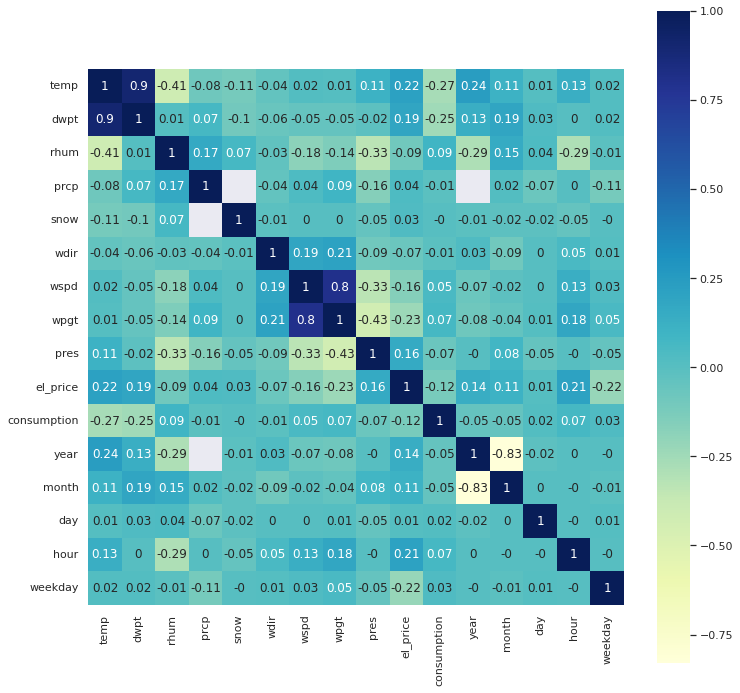

In [99]:
plt.figure(figsize=(12, 12))

cov_matrix = train.corr()
sns.heatmap(cov_matrix.round(2), annot=True, cmap="YlGnBu", square=True)
plt.show()

<AxesSubplot: >

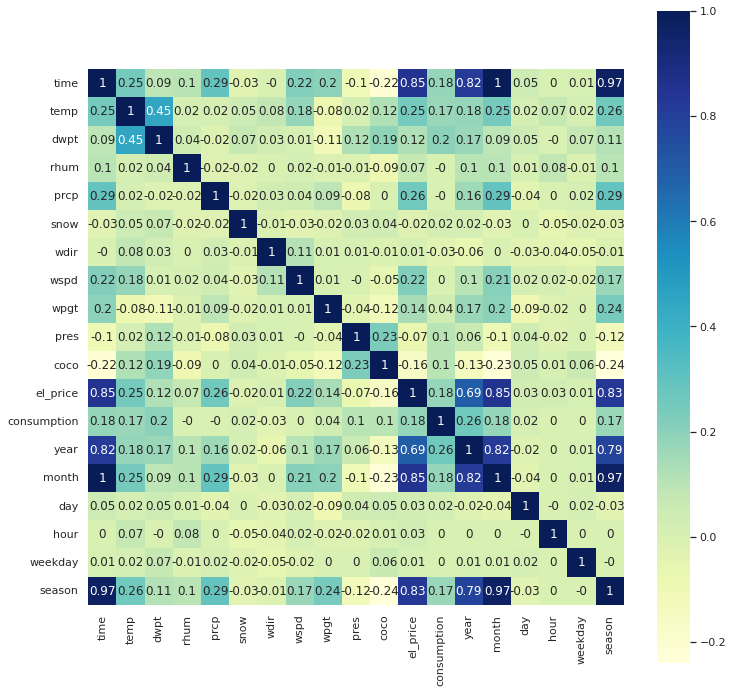

In [100]:
# Correlation method I found at https://stackoverflow.com/questions/48035381/correlation-among-multiple-categorical-variables-pandas
# Might give completely wrong information, I do not understand its asumptions
# From what I understand it transforms categorical to nominal values and computes correlation

plt.figure(figsize=(12, 12))

train_corr = train.apply(lambda x: pd.factorize(x)[0]).corr().round(2)

sns.heatmap(train_corr, annot=True, cmap="YlGnBu", square=True)

## Data modification

In [101]:
# USE the code we wrote above
#train = train.drop(["consumption"], axis=1)
train['consumption'] = train['consumption'].astype('float32')

train_no_time = train.copy()
train_no_time.drop(["time", "coco", "season"], axis=1, inplace=True)
test_no_time = test.copy()
test_no_time.drop(["time", "coco", "season"], axis=1, inplace=True)
test_no_time, train_no_time, labels = replaceNanWithZero(
    test_no_time, train_no_time, train_labels
)

PCA_Performance(train_no_time, test_no_time)

Retained 0.5 of variance with 1 number of features
Retained 0.6 of variance with 1 number of features
Retained 0.75 of variance with 1 number of features
Retained 0.8 of variance with 1 number of features
Retained 0.85 of variance with 1 number of features
Retained 0.9 of variance with 2 number of features
Retained 0.95 of variance with 4 number of features
Retained 0.96 of variance with 4 number of features
Retained 0.97 of variance with 5 number of features
Retained 0.98 of variance with 6 number of features
Retained 0.99 of variance with 7 number of features


In [102]:
lstm_train = train_no_time
lstm_train['time'] = pd.to_datetime(train['time'])#.astype(int).astype('int32')
lstm_train.set_index('time', inplace=True)
lstm_test = test_no_time
lstm_test['time'] = pd.to_datetime(test['time'])#.astype(int).astype('int32')
lstm_test.set_index('time', inplace=True)
lstm_train.head()


,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,el_price,consumption,year,month,day,hour,weekday
time,,,,,,,,,,,,,,,,
2021-09-01 00:00:00+03:00,11.2,10.3,94,0.0,0.0,320,7.2,16.700001,1012.599976,0.09016,0.577,2021,9,1,0,2
2021-09-01 01:00:00+03:00,10.7,9.6,93,0.0,0.0,320,7.2,13.000000,1012.599976,0.09251,0.594,2021,9,1,1,2
2021-09-01 02:00:00+03:00,9.9,9.0,94,0.0,0.0,320,7.2,13.000000,1012.200012,0.08890,0.685,2021,9,1,2,2
2021-09-01 03:00:00+03:00,10.0,8.4,90,0.0,0.0,330,7.2,13.000000,1011.900024,0.08735,1.016,2021,9,1,3,2
2021-09-01 04:00:00+03:00,9.0,8.1,94,0.0,0.0,300,3.6,13.000000,1011.400024,0.08688,0.677,2021,9,1,4,2


In [103]:
lstm_test.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,el_price,year,month,day,hour,weekday
time,,,,,,,,,,,,,,,
2022-08-25 00:00:00+03:00,21.100000,15.2,69,0.0,0.0,340,9.0,9.3,1022.000000,0.25533,2022,8,25,0,3
2022-08-25 01:00:00+03:00,20.100000,15.1,73,0.0,0.0,30,6.0,14.8,1022.000000,0.19492,2022,8,25,1,3
2022-08-25 02:00:00+03:00,20.100000,15.1,73,0.0,0.0,320,7.0,13.0,1022.000000,0.18853,2022,8,25,2,3
2022-08-25 03:00:00+03:00,18.700001,17.0,90,0.0,0.0,0,4.0,11.1,1022.400024,0.19947,2022,8,25,3,3
2022-08-25 04:00:00+03:00,18.100000,17.1,94,0.0,0.0,280,7.0,11.1,1022.000000,0.21192,2022,8,25,4,3


In [104]:
!pip install darts==0.22.0 statsforecast==1.3.2
from darts import TimeSeries
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [156]:
from darts import TimeSeries
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries, holidays_timeseries

full = lstm_train.append(lstm_test)
#s_train = TimeSeries.from_dataframe(lstm_train, None, None)
#s_test = TimeSeries.from_dataframe(lstm_test, None, None)
series = TimeSeries.from_dataframe(full, None, None)
p_series = TimeSeries.from_dataframe(pd.DataFrame(full['consumption']).astype('double'))
s_train, s_test = p_series.split_after(pd.Timestamp('2022-08-24 23:00:00+03:00'))

transformer = Scaler()
train_transformed = transformer.fit_transform(s_train)
val_transformed = transformer.transform(s_test)
series_transformed = transformer.transform(p_series)

val_transformed = TimeSeries.from_values(np.nan_to_num(val_transformed.values()))
assert(not np.any(np.isnan(val_transformed.all_values())))

year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), end=series.end_time(), freq=series.freq_str),#periods=10000
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
weekday_series = datetime_attribute_timeseries(
    month_series, attribute="weekday", one_hot=True
)
day_series = datetime_attribute_timeseries(
    weekday_series, attribute="day", one_hot=True
)
hour_series = datetime_attribute_timeseries(
    day_series, attribute="hour", one_hot=True
)
holiday_series = holidays_timeseries(
    pd.date_range(start=series.start_time(), end=series.end_time(), freq=series.freq_str),
    'EE'
)
covariates = year_series.stack(month_series).stack(month_series).stack(weekday_series).stack(holiday_series).stack(day_series).stack(hour_series)
tmp_series = hour_series
for c in ['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'el_price']:
    tmp_series = TimeSeries.from_dataframe(pd.DataFrame(full[c]))
    covariates = covariates.stack(tmp_series)

cov_train, cov_val = covariates.split_after(pd.Timestamp("2022-08-24 23:00:00+03:00"))

In [149]:
covariates.all_values().shape

(8760, 98, 1)

In [159]:
lstm = RNNModel(
    model="LSTM",
    hidden_dim=24,
    dropout=0.2,
    batch_size=16,
    n_epochs=128,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Elec_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=48,
    input_chunk_length=24,
    force_reset=True,
    save_checkpoints=True,
)
lstm.fit(
    train_transformed,
    future_covariates=covariates,
    #val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True
)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 12.0 K
4 | V             | Linear           | 25    
---

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=128` reached.


In [164]:
pred_series = lstm.predict(n=len(s_test), future_covariates=covariates)

Predicting: 534it [00:00, ?it/s]

In [169]:
pred_series.to_csv('pred.csv')